# Unsupervised clustering - find best LDA model based on coherence

## Dataset loading

In [1]:
import pandas as pd

df = pd.read_csv("20230214-dataset_preprocessed_with_lemma.csv", index_col=0)
df.head()

title_texte     85     44     50  \
1   ipa supply equipment increase competitiveness...  False   True  False   
3   provision language training service tender in...  False  False  False   
4   service support eda helicopter portfolio main...  False  False  False   
5   NUMBER cp op NUMBER pooling share cost non co...  False  False  False   
6   edf supply transport household similar waste ...  False  False  False   

      80     73     45     71     79     90  ...     18     03     24     43  \
1  False  False  False  False  False  False  ...  False  False  False  False   
3   True  False  False  False  False  False  ...  False  False  False  False   
4   True  False  False  False  False  False  ...  False  False  False  False   
5  False   True  False  False  False  False  ...  False  False  False  False   
6  False  False   True  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
1  False  False  False  False  False  False  
3  False  False  False  False  False  False  
4  False  False  False  False  False  False  
5  False  False  False  False  False  False  
6  False  False  False  False  False  False  

[5 rows x 46 columns]

In [2]:
from sklearn.model_selection import train_test_split

cpvs = [c for c in df.columns if len(c) == 2]
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)
(df_train.shape, df_test.shape)

((11647, 46), (2912, 46))

In [3]:
{c: df_train[c].sum() for c in cpvs}

{'85': 256,
 '44': 103,
 '50': 297,
 '80': 403,
 '73': 1067,
 '45': 731,
 '71': 1621,
 '79': 2682,
 '90': 629,
 '30': 266,
 '35': 145,
 '33': 158,
 '55': 117,
 '72': 914,
 '48': 199,
 '38': 289,
 '09': 128,
 '75': 277,
 '66': 206,
 '64': 148,
 '42': 159,
 '34': 199,
 '60': 122,
 '92': 169,
 '39': 188,
 '31': 139,
 '98': 123,
 '51': 50,
 '32': 185,
 '65': 29,
 '77': 83,
 '22': 61,
 '63': 144,
 '15': 43,
 '70': 44,
 '18': 35,
 '03': 31,
 '24': 30,
 '43': 17,
 '19': 7,
 '41': 13,
 '37': 13,
 '14': 16,
 '16': 5,
 '76': 5}

In [4]:
{c: df_test[c].sum() for c in cpvs}

{'85': 62,
 '44': 23,
 '50': 68,
 '80': 99,
 '73': 249,
 '45': 191,
 '71': 404,
 '79': 688,
 '90': 176,
 '30': 70,
 '35': 36,
 '33': 38,
 '55': 30,
 '72': 197,
 '48': 43,
 '38': 61,
 '09': 34,
 '75': 77,
 '66': 46,
 '64': 37,
 '42': 27,
 '34': 50,
 '60': 41,
 '92': 43,
 '39': 49,
 '31': 36,
 '98': 35,
 '51': 8,
 '32': 40,
 '65': 15,
 '77': 22,
 '22': 20,
 '63': 34,
 '15': 5,
 '70': 14,
 '18': 5,
 '03': 5,
 '24': 11,
 '43': 1,
 '19': 5,
 '41': 2,
 '37': 3,
 '14': 6,
 '16': 4,
 '76': 3}

In [5]:
import gensim

processed_docs = df_train["title_texte"].apply(lambda x: x.split(" "))
processed_docs_test = df_train["title_texte"].apply(lambda x: x.split(" "))

dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

## Find good number of topics

In [7]:
from tqdm import tqdm
from gensim.models import CoherenceModel

topic_counts = range(2, 100, 2)
coherences = []

for topic_count in tqdm(topic_counts, total=len(topic_counts)):
    lda_model = gensim.models.LdaModel(bow_corpus, num_topics=topic_count, id2word=dictionary, passes=2,
                                       minimum_probability=0.0, random_state=0)
    lda_coherence_model = CoherenceModel(model=lda_model, texts=processed_docs_test, dictionary=dictionary,
                                         coherence='c_v')
    coherences.append(lda_coherence_model.get_coherence())

100%|██████████| 49/49 [10:37<00:00, 13.01s/it]


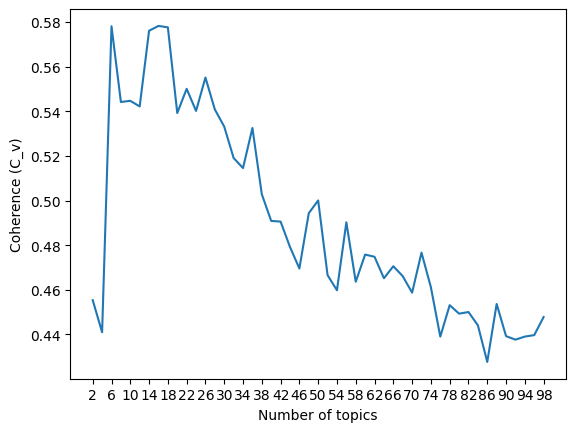

In [12]:
from matplotlib import pyplot as plt

plt.plot(topic_counts, coherences)
plt.xticks(range(2, 100, 4), range(2, 100, 4))
plt.xlabel("Number of topics")
plt.ylabel("Coherence (C_v)")
plt.show()

Two local maxima found: at 6 and in range [14; 18].
Let's take 18 topics.

## Find good number of passes

In [35]:
from tqdm import tqdm
from gensim.models import CoherenceModel

pass_counts = range(2, 30, 4)
coherences = []

for pass_count in tqdm(pass_counts, total=len(pass_counts)):
    lda_model = gensim.models.LdaModel(bow_corpus, num_topics=18, id2word=dictionary, passes=pass_count,
                                       minimum_probability=0.0, random_state=0)
    lda_coherence_model = CoherenceModel(model=lda_model, texts=processed_docs_test, dictionary=dictionary,
                                         coherence='c_v')
    coherences.append(lda_coherence_model.get_coherence())

100%|██████████| 7/7 [03:14<00:00, 27.79s/it]


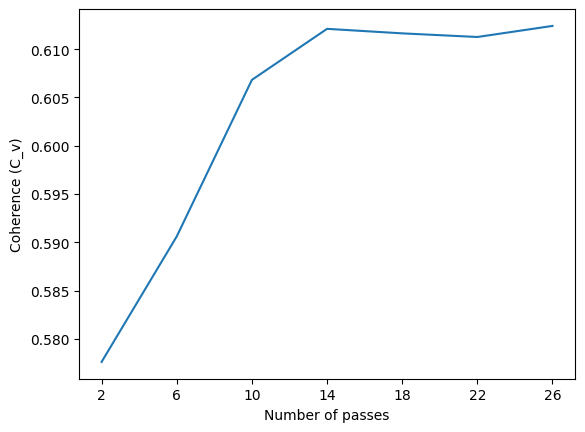

In [36]:
plt.plot(pass_counts, coherences)
plt.xticks(pass_counts, pass_counts)
plt.xlabel("Number of passes")
plt.ylabel("Coherence (C_v)")
plt.show()

10 passes seems to be a good balance between training time and performance

## Grid search for alpha and eta hyperparameters

In [13]:
from numpy import arange
from tqdm import tqdm
from gensim.models import CoherenceModel

topic_count = 18
pass_count = 10
alpha_vals = list(arange(0.1, 1., 0.2)) + ['symmetric', 'asymmetric', 'auto']
eta_vals = list(arange(0.1, 1., 0.2)) + ['symmetric', 'auto']

params = []
coherences = []
for alpha in tqdm(alpha_vals, total=len(alpha_vals)):
    for eta in tqdm(eta_vals, total=len(eta_vals)):
        lda_model = gensim.models.LdaModel(bow_corpus, num_topics=topic_count, id2word=dictionary, passes=pass_count,
                                           minimum_probability=0.0, random_state=0, alpha=alpha, eta=eta)
        lda_coherence_model = CoherenceModel(model=lda_model, texts=processed_docs_test, dictionary=dictionary,
                                             coherence='c_v')
        coherences.append(lda_coherence_model.get_coherence())
        params.append((alpha, eta))

100%|██████████| 8/8 [21:08<00:00, 158.61s/it]


In [19]:
results = pd.DataFrame(params, columns=["alpha", "eta"])
results['coherence'] = coherences
results

alpha        eta  coherence
0          0.1        0.1   0.591410
1          0.1        0.3   0.590619
2          0.1        0.5   0.604507
3          0.1        0.7   0.593771
4          0.1        0.9   0.588428
5          0.1  symmetric   0.593764
6          0.1       auto   0.593764
7          0.3        0.1   0.545852
8          0.3        0.3   0.543587
9          0.3        0.5   0.545267
10         0.3        0.7   0.547948
11         0.3        0.9   0.545067
12         0.3  symmetric   0.542743
13         0.3       auto   0.542743
14         0.5        0.1   0.594534
15         0.5        0.3   0.603920
16         0.5        0.5   0.605625
17         0.5        0.7   0.602780
18         0.5        0.9   0.602691
19         0.5  symmetric   0.590724
20         0.5       auto   0.590724
21         0.7        0.1   0.573548
22         0.7        0.3   0.571211
23         0.7        0.5   0.573821
24         0.7        0.7   0.571404
25         0.7        0.9   0.575992
26         0.7  symmetric   0.580720
27         0.7       auto   0.580720
28         0.9        0.1   0.598190
29         0.9        0.3   0.589366
30         0.9        0.5   0.590532
31         0.9        0.7   0.593980
32         0.9        0.9   0.598783
33         0.9  symmetric   0.596835
34         0.9       auto   0.596835
35   symmetric        0.1   0.609470
36   symmetric        0.3   0.610043
37   symmetric        0.5   0.618075
38   symmetric        0.7   0.602709
39   symmetric        0.9   0.608895
40   symmetric  symmetric   0.606818
41   symmetric       auto   0.606818
42  asymmetric        0.1   0.603349
43  asymmetric        0.3   0.605684
44  asymmetric        0.5   0.613109
45  asymmetric        0.7   0.612604
46  asymmetric        0.9   0.612228
47  asymmetric  symmetric   0.602633
48  asymmetric       auto   0.602633
49        auto        0.1   0.611178
50        auto        0.3   0.611255
51        auto        0.5   0.615496
52        auto        0.7   0.603420
53        auto        0.9   0.600422
54        auto  symmetric   0.608649
55        auto       auto   0.608649

In [20]:
max_params = (0, 0)
max_coherence = 0
for (alpha, eta), coherence in zip(params, coherences):
    if coherence > max_coherence:
        max_coherence = coherence
        max_params = (alpha, eta)
print(f"Max coherence of {max_coherence} for alpha={max_params[0]} and eta={max_params[1]}")

Max coherence of 0.6180751847981156 for alpha=symmetric and eta=0.5000000000000001
